In [3]:
%matplotlib inline

from IPython.display import display as d
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12)})
sns.set_style("white")
import glob
import json
import os
import sys
import json
import shutil
import os
import sys
import multiprocessing
import shutil
pool = multiprocessing.Pool(multiprocessing.cpu_count())


In [4]:
def read_json(x):
    with open(x) as xfp:
        return json.load(xfp)

    

In [5]:
from sklearn.metrics import *
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt

def calc_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "mcc": matthews_corrcoef(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

def plot_confusion_matrix(confusion_matrix, display_labels, include_values=True, values_format=None, 
                          xticks_rotation=0, pdf=None,
                         cmap=plt.cm.Blues):
    import matplotlib.pyplot as plt
    import itertools
    fig, ax = plt.subplots(figsize=(5, 4))


    cm = confusion_matrix
    n_classes = cm.shape[0]
    im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    text_ = None

    cmap_min, cmap_max = im_.cmap(0), im_.cmap(256)

    if include_values:
        text_ = np.empty_like(cm, dtype=object)
        if values_format is None:
            values_format = '.2g'

        # print text with appropriate color depending on background
        thresh = (cm.max() + cm.min()) / 2.0
        for i, j in itertools.product(range(n_classes), range(n_classes)):
            color = cmap_max if cm[i, j] < thresh else cmap_min
            text_[i, j] = ax.text(j, i,
                                       format(cm[i, j], values_format),
                                       ha="center", va="center",
                                       color=color)

    #fig.colorbar(im_, ax=ax)
    ax.set(xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=display_labels,
           yticklabels=display_labels,
           ylabel="True label",
           xlabel="Predicted label")

    ax.set_ylim((n_classes - 0.5, -0.5))
    plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
    figure_ = fig
    if pdf is None:
        return ax
    ax.get_figure().savefig(pdf, bbox_inches="tight")
    return ax

In [6]:


def perform_analysis(dataset, figure_dir="figures"):
    os.makedirs("figures", exist_ok=True)
    
    df = pd.DataFrame(list(map(read_json, list(glob.glob(f"data/traning_and_validation/{dataset}/results/*.json")))))

    d(df.head())

    needed_cols = ["val_binary_accuracy", "binary_accuracy", "loss", "val_loss"]
    da = pd.DataFrame()
    for m, grp in df.groupby(by="model"):
        v = {
            "epoch": list(range(200)),
            "model": [m for _ in range(200)]
        }
        for col in needed_cols:
            v[col] = grp.iloc[0][col]
        dv = pd.DataFrame(v)
        da = da.append(dv, ignore_index=True)
    sns.set(rc={'figure.figsize':(24,12)})
    sns.set_style("white")

    sns.lineplot(y="val_binary_accuracy", x="epoch", hue="model", data=da)
    d(da.head())
    plt.show()
    sns.boxplot(y="model", x="val_binary_accuracy", data=da)
    
    db = da.groupby(by="model").max().reset_index()[["model", "val_binary_accuracy"]].sort_values(
        by="val_binary_accuracy",
        ascending=False
    )
    d(db)

    metrics_values = []
    for curr_model in db["model"].values:
        row = df[df["model"] == curr_model].iloc[0]
        classes = row["classnames"]
        truth = row["truth"]
        pred = [1 if x > 0.5 else 0 for x in row["pred"]]

        metrics = calc_metrics(truth, pred)
        metrics["model"] = curr_model
        metrics_values.append(metrics)

    dm = pd.DataFrame(metrics_values).sort_values(by="accuracy", ascending=False)
    d(dm)
    dm[["model", "accuracy", "precision", "recall", "f1", "mcc"]].round(3).to_latex(f"val_{dataset}.tex", index=False)
    cm = confusion_matrix(truth, pred)
    # normalize 
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    
    best_model = dm["model"].values[0]
    
    ax = plot_confusion_matrix(
        confusion_matrix=cm_norm,
        display_labels=classes,
        cmap=plt.cm.Greys if dataset=="rule_of_thirds" else plt.cm.Greens
    )
    ax.set_title(f"""{dataset.replace("_", " ").title()}: {best_model} (best)""")
    pdf = f"./figures/confusion_{dataset}_{best_model}.pdf"
    ax.get_figure().savefig(pdf, bbox_inches="tight")


,binary_accuracy,classnames,loss,model,pred,truth,val_binary_accuracy,val_loss,validation_files
0,"[0.6800731420516968, 0.8531383275985718, 0.927...","[negative, positive]","[1.5739573240280151, 0.44653457403182983, 0.19...",DenseNet169,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999792575836...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6620879173278809, 0.7609890103340149, 0.744...","[1.5819132328033447, 0.9546176791191101, 1.014...",[data/rule_of_thirds/negative/images/111577271...
1,"[0.7528945803642273, 0.9244363307952881, 0.962...","[negative, positive]","[1.1435314416885376, 0.332270085811615, 0.1184...",MobileNet,"[0.0, 0.0, 8.456955251720757e-33, 0.0, 0.00024...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.807692289352417, 0.8021978139877319, 0.7774...","[0.9968104362487793, 1.0958211421966553, 1.482...",[data/rule_of_thirds/negative/images/111577271...
2,"[0.67641681432724, 0.821755051612854, 0.886349...","[negative, positive]","[1.1774909496307373, 0.5989974141120911, 0.353...",Xception,"[2.389577642114273e-30, 0.0, 1.091489175183428...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.7252747416496277, 0.7142857313156128, 0.739...","[0.8917350172996521, 1.3459681272506714, 0.936...",[data/rule_of_thirds/negative/images/111577271...
3,"[0.7522851824760437, 0.9186471700668335, 0.952...","[negative, positive]","[2.3182566165924072, 0.6710180044174194, 0.283...",ResNet152,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.000163545308168977...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.791208803653717, 0.7884615659713745, 0.8076...","[1.9806687831878662, 2.472907543182373, 2.6025...",[data/rule_of_thirds/negative/images/111577271...
4,"[0.7452772855758667, 0.9250457286834717, 0.966...","[negative, positive]","[2.6080515384674072, 0.5236702561378479, 0.177...",ResNet50,"[0.0, 0.0, 0.0, 0.0, 2.8517508538944182e-27, 6...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.807692289352417, 0.7994505763053894, 0.8104...","[1.7535498142242432, 2.1133193969726562, 2.370...",[data/rule_of_thirds/negative/images/111577271...


,epoch,model,val_binary_accuracy,binary_accuracy,loss,val_loss
0,0,DenseNet121,0.760989,0.690128,1.139634,0.757432
1,1,DenseNet121,0.760989,0.841560,0.481171,0.874890
2,2,DenseNet121,0.741758,0.890311,0.320961,1.079255
3,3,DenseNet121,0.769231,0.905545,0.272735,0.955447
4,4,DenseNet121,0.739011,0.937843,0.151077,1.105832


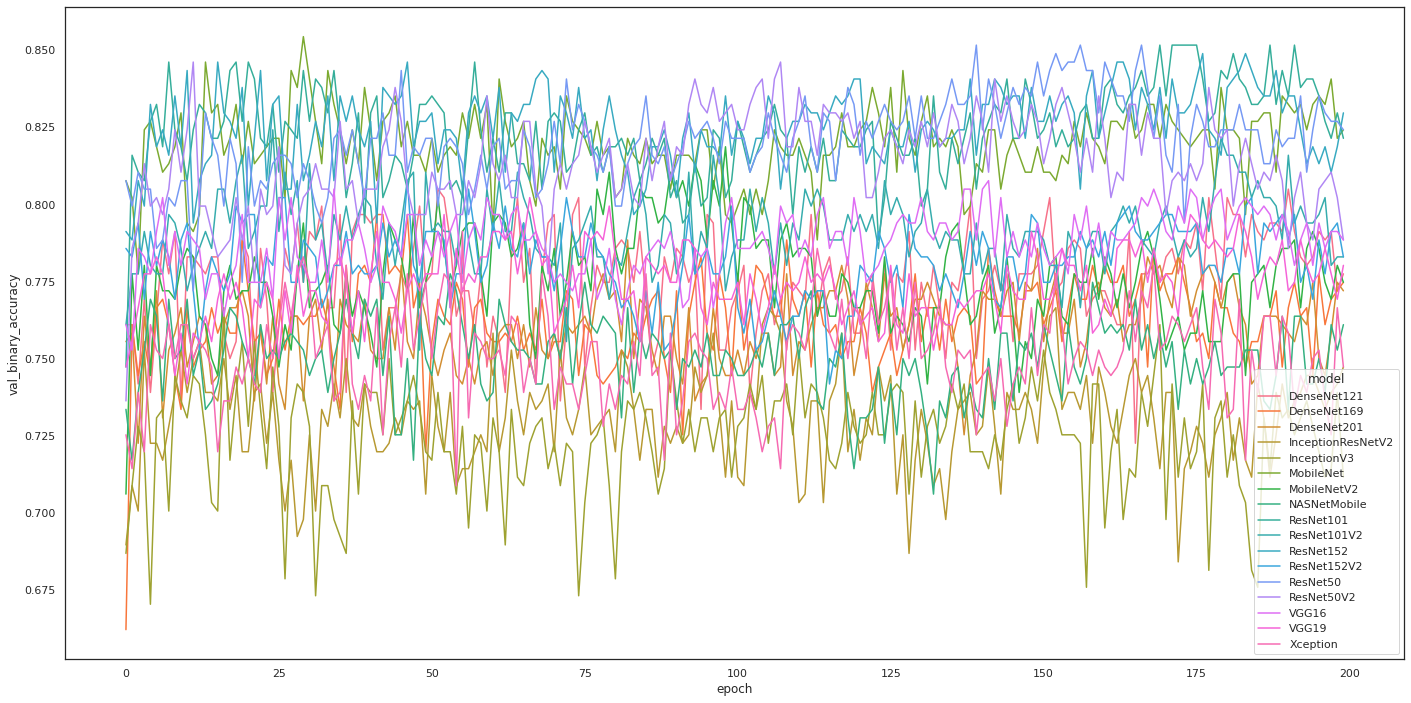

,model,val_binary_accuracy
5,MobileNet,0.854396
8,ResNet101,0.851648
12,ResNet50,0.851648
10,ResNet152,0.848901
13,ResNet50V2,0.846154
9,ResNet101V2,0.824176
6,MobileNetV2,0.818681
14,VGG16,0.807692
11,ResNet152V2,0.807692
0,DenseNet121,0.804945


,accuracy,precision,recall,f1,mcc,confusion_matrix,model
3,0.840659,0.835052,0.861702,0.848168,0.680996,"[[144, 32], [26, 162]]",ResNet152
0,0.826923,0.820513,0.851064,0.835509,0.653515,"[[141, 35], [28, 160]]",MobileNet
2,0.826923,0.823834,0.845745,0.834646,0.653403,"[[142, 34], [29, 159]]",ResNet50
1,0.818681,0.863095,0.771277,0.814607,0.642149,"[[153, 23], [43, 145]]",ResNet101
4,0.799451,0.791878,0.829787,0.810390,0.598545,"[[135, 41], [32, 156]]",ResNet50V2
5,0.796703,0.787879,0.829787,0.808290,0.593126,"[[134, 42], [32, 156]]",ResNet101V2
7,0.791209,0.807692,0.781915,0.794595,0.582734,"[[141, 35], [41, 147]]",VGG16
10,0.782967,0.818713,0.744681,0.779944,0.569276,"[[145, 31], [48, 140]]",VGG19
6,0.780220,0.850649,0.696809,0.766082,0.572636,"[[153, 23], [57, 131]]",MobileNetV2
8,0.774725,0.765000,0.813830,0.788660,0.549180,"[[129, 47], [35, 153]]",ResNet152V2


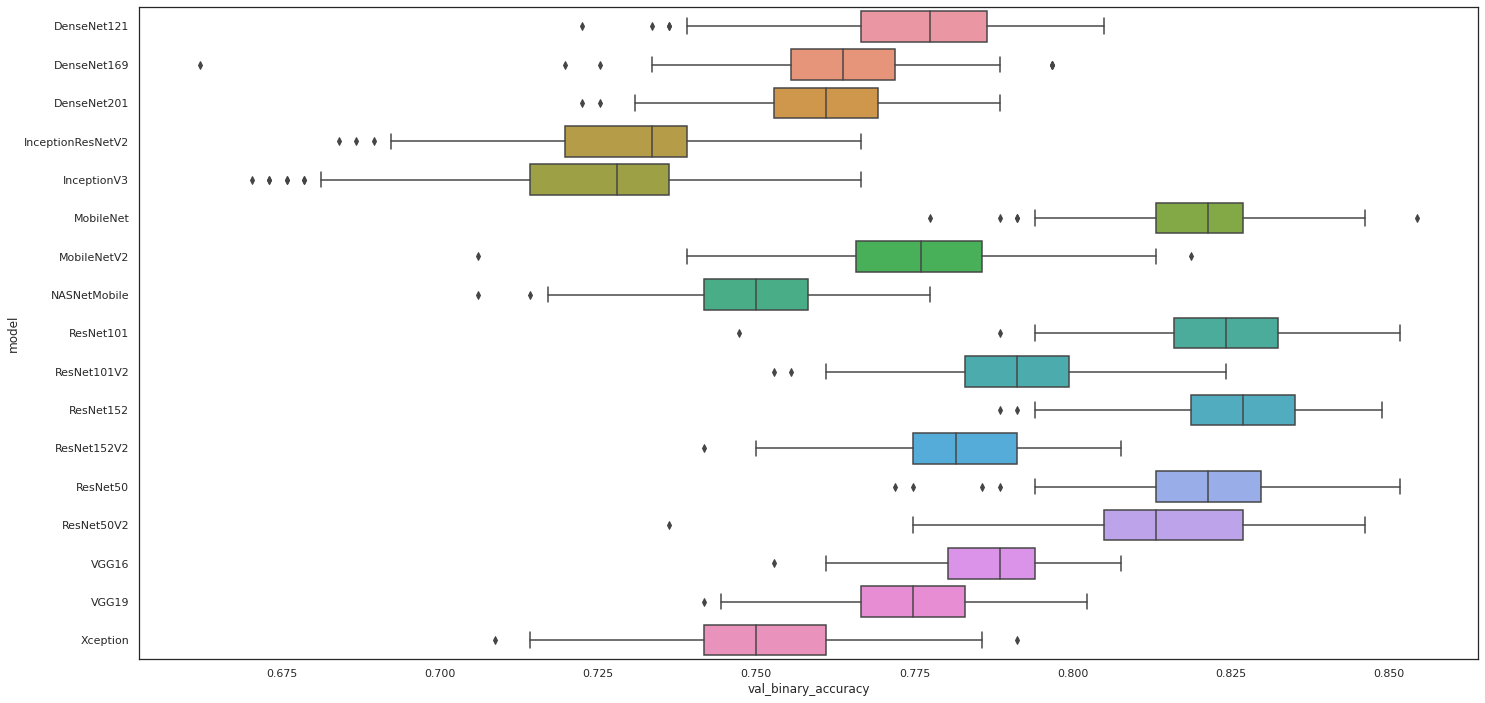

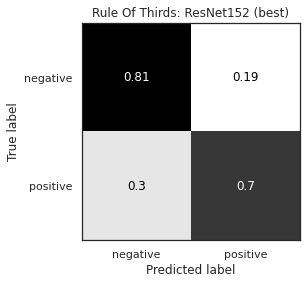

In [7]:
perform_analysis("rule_of_thirds")

,binary_accuracy,classnames,loss,model,pred,truth,val_binary_accuracy,val_loss,validation_files
0,"[0.8603905439376831, 0.930632472038269, 0.9542...","[false, true]","[0.6420148611068726, 0.2817954123020172, 0.195...",DenseNet169,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.584...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8950130939483643, 0.8635170459747314, 0.918...","[0.5697384476661682, 0.9736284613609314, 0.760...",[data/image_simplicity/false/10112_Copyrighted...
1,"[0.8877878189086914, 0.9705625176429749, 0.990...","[false, true]","[0.6234116554260254, 0.10860320180654526, 0.03...",MobileNet,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.66239559...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8845144510269165, 0.9160104990005493, 0.908...","[0.7674115896224976, 0.6249551773071289, 0.699...",[data/image_simplicity/false/10112_Copyrighted...
2,"[0.8265811800956726, 0.9341300129890442, 0.958...","[false, true]","[0.6612198948860168, 0.21597453951835632, 0.11...",Xception,"[0.0, 0.0, 8.343447721395612e-20, 3.9693924719...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8897637724876404, 0.8661417365074158, 0.897...","[0.6438666582107544, 0.5918327569961548, 0.587...",[data/image_simplicity/false/10112_Copyrighted...
3,"[0.8828330039978027, 0.9658991694450378, 0.969...","[false, true]","[1.0730030536651611, 0.28313425183296204, 0.27...",ResNet152,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8897637724876404, 0.8950130939483643, 0.918...","[1.7469446659088135, 1.575837254524231, 1.7196...",[data/image_simplicity/false/10112_Copyrighted...
4,"[0.8860390782356262, 0.9551151394844055, 0.985...","[false, true]","[1.0957810878753662, 0.4018099904060364, 0.105...",ResNet50,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.913385808467865, 0.9238845109939575, 0.9107...","[1.0379996299743652, 1.3693149089813232, 1.613...",[data/image_simplicity/false/10112_Copyrighted...


,epoch,model,val_binary_accuracy,binary_accuracy,loss,val_loss
0,0,DenseNet121,0.913386,0.871758,0.501203,0.454670
1,1,DenseNet121,0.874016,0.946663,0.196862,0.845552
2,2,DenseNet121,0.892388,0.968231,0.091325,0.639771
3,3,DenseNet121,0.902887,0.975809,0.074935,0.601033
4,4,DenseNet121,0.916010,0.969688,0.096196,0.642228


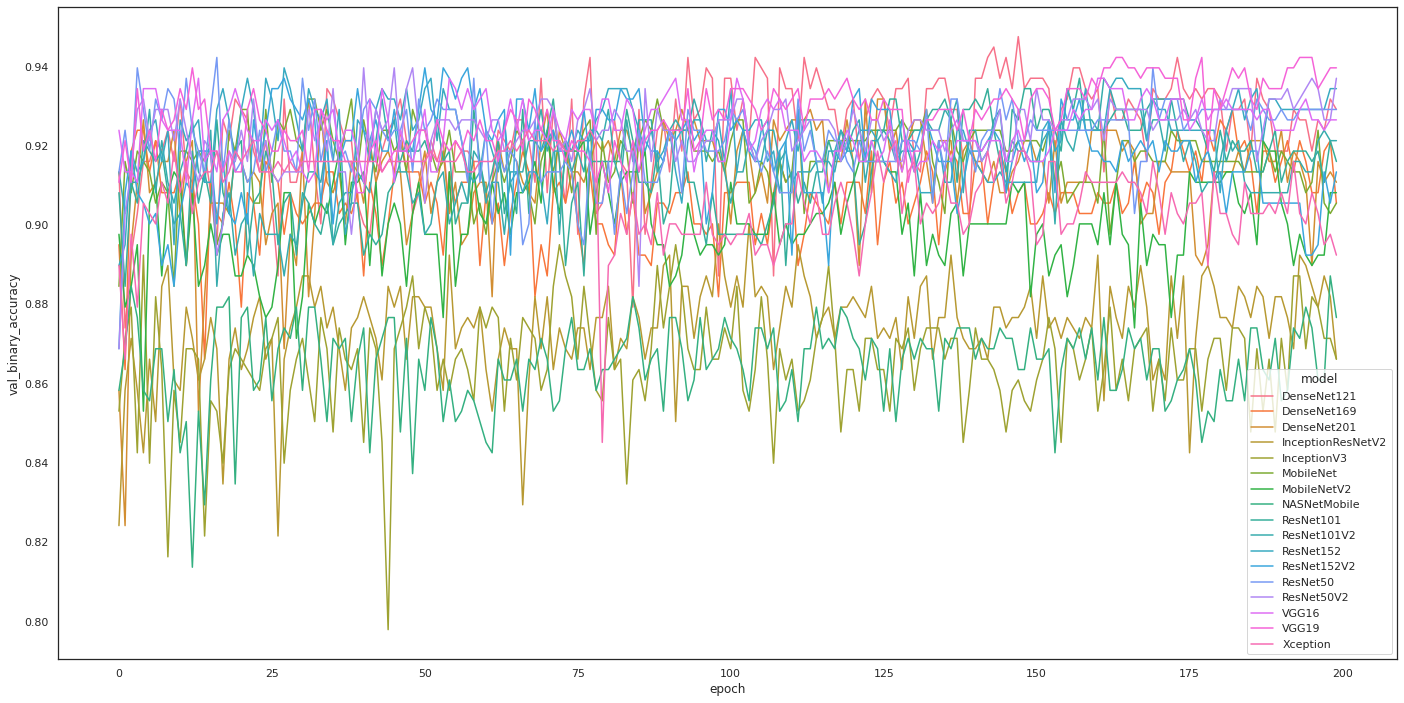

,model,val_binary_accuracy
0,DenseNet121,0.947507
15,VGG19,0.942257
12,ResNet50,0.942257
13,ResNet50V2,0.939633
11,ResNet152V2,0.939633
10,ResNet152,0.939633
9,ResNet101V2,0.937008
14,VGG16,0.937008
8,ResNet101,0.937008
5,MobileNet,0.931759


,accuracy,precision,recall,f1,mcc,confusion_matrix,model
0,0.939633,0.951613,0.926702,0.938992,0.879576,"[[181, 9], [14, 177]]",DenseNet121
2,0.934383,0.941489,0.926702,0.934037,0.868879,"[[179, 11], [14, 177]]",ResNet50
1,0.934383,0.941489,0.926702,0.934037,0.868879,"[[179, 11], [14, 177]]",VGG19
7,0.931759,0.918782,0.947644,0.932990,0.863934,"[[174, 16], [10, 181]]",VGG16
3,0.929134,0.927083,0.931937,0.929504,0.858277,"[[176, 14], [13, 178]]",ResNet50V2
10,0.929134,0.922680,0.937173,0.929870,0.858367,"[[175, 15], [12, 179]]",DenseNet201
8,0.923885,0.921875,0.926702,0.924282,0.847778,"[[175, 15], [14, 177]]",ResNet101
4,0.923885,0.921875,0.926702,0.924282,0.847778,"[[175, 15], [14, 177]]",ResNet152V2
6,0.918635,0.934783,0.900524,0.917333,0.837851,"[[178, 12], [19, 172]]",ResNet101V2
5,0.916010,0.944134,0.884817,0.913514,0.833703,"[[180, 10], [22, 169]]",ResNet152


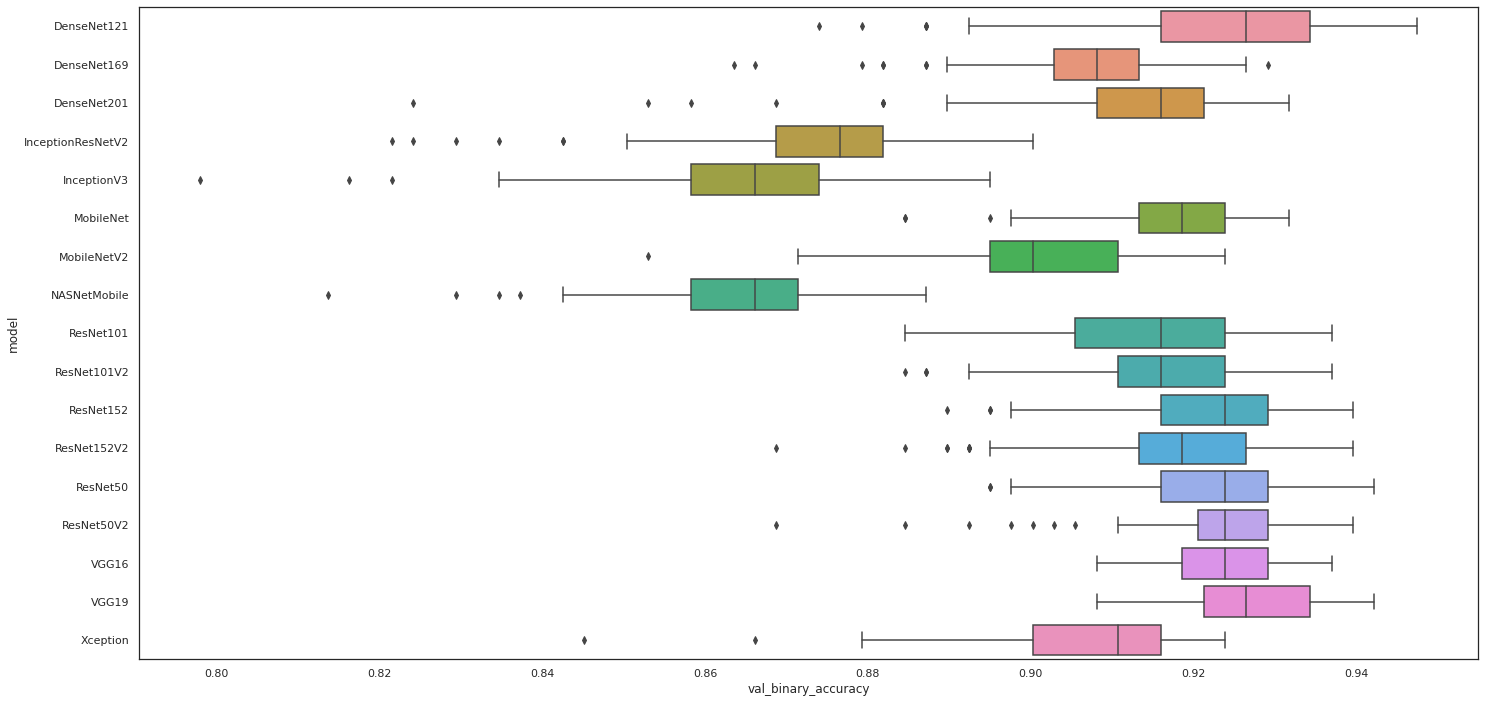

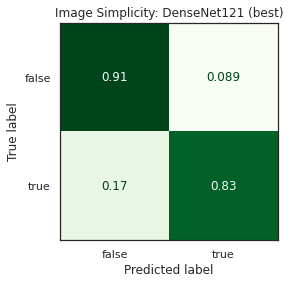

In [8]:
perform_analysis("image_simplicity")